**Cole Turner and Ethan Seal**

Fall 2019

CS343: Neural Networks

Project 5: Word embeddings and SOMs

In [165]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import word2vec

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=7)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Project 5: Word Embeddings and SOMs overview

In this project, we will train a Skip-gram (word2vec) neural network commonly used in the field of natural language processing (NLP) on text from IMDb user movie reviews. The goal of the network is to predict context words (words surrounding each word in a sentence). After implementing and training the network, you will extract the weights to obtain $H$ dimensional **word embedding** vectors for English words that appeared in the movie reviews. Because the Skip-gram network is just a slight variant of a softmax classifier with a dense hidden layer, you will leverage the network infrastructure that you developed in the convolutional neural network project.

In the second part of the project (`som.ipynb`), you will implement a self-organizing map (SOM), a cooperative biologically-inspired neural network. This network will learn the nonlinear structure of the IMDb word embeddings (in $H$ dimensions) (unsupervised learning) and allow us to visualize the words in 2D. Remarkably, words with similar meanings should appear nearby each other, even though the network knows nothing about the definitions of the words!

## Task 1) Preprocess IMDb review dataset

### a. Load in IMDb review data

Load in the movie review text data in `imdb_train.csv`. The goal is to get a Python list of length 25,000 (there are 25,000 reviews in the training set), where element $i$ is a single string representing the $i^{th}$ review. You're welcome to do this however you like. I suggest using pandas.

In [167]:
imdb_train = pd.read_csv('imdb/imdb_train.csv', delimiter='\t')
all_reviews = imdb_train['review'].to_numpy(dtype=str)
all_reviews = all_reviews.tolist()

#### Extract a subset of reviews

- Make a variable that represents the number of reviews that we will take out of the full training set (I'm calling $R$ in instructions, but call it what you want). 

Larger numbers will increase simulation time and memory usage, so pick a value on the small side for testing and scale it up based on your machine's performance. To give you a baseline, I started with 3 reviews during testing and increased it to 50 reviews for "real" simulations. **The test code below assumes $R=10$**, the 1st 10 non-shuffled reviews (you can change this later before doing neural network simulations).
- Use the variable to select the first $R$ reviews from the dataset.

In [168]:
R = 10
reviews = all_reviews[:R]


### b. Make corpus

In NLP, we usually define a **corpus**, which is the set of documents from which we're interested in learning. For the IMDb dataset and Skip-gram network, this represents a list of sentences across all the reviews (from the subset that we selected). The problem is that our reviews are chunked by review, not sentence.

- In `word2vec.py` implement `make_corpus()`, which will build a list where elements are sentences, not reviews.

In [169]:
corpus = word2vec.make_corpus(reviews)
print(f'There are {len(corpus)} sentences in the corpus. There should be 99.')

There are 99 sentences in the corpus. There should be 99.


#### Identify unique words and vocabulary size

Now that we have a corpus of sentences, let's figure out the **vocabulary size**, defined as the number of unique words in the corpus (across all the sentences).
- In `word2vec.py` implement `find_unique_words()` that returns a list of unique words in the corpus.
- Define `vocab_sz` as the vocab size

In [170]:
unique_words = word2vec.find_unique_words(corpus)
vocab_sz = len(unique_words)
print(f'There are {vocab_sz} words in the vocabulary. There should be 1016.')

There are 1016 words in the vocabulary. There should be 1016.


#### Make word <-> unique word index lookup tables

It will be useful to assign an int code to each unique word in the range `[0, vocab_sz-1]`.
- Write `word2vec.make_word2ind_mapping`. This makes a Python dictionary `word2ind` that allows you to use a word string to look up its int code.
- Write `word2vec.make_ind2word_mapping`. This makes a Python dictionary `ind2word` that allows you to use a word int code to look up its word string.

In [171]:
# Make word -> index lookup table
word2ind = word2vec.make_word2ind_mapping(unique_words)
ind2word = word2vec.make_ind2word_mapping(unique_words)
print(f'If you preserved the order of words, the int code for "robot" is {word2ind["robot"]} and should be 159.')
print(f'If you preserved the order of words, the int code for "fans" is {word2ind["fans"]} and should be 108.')
      
print(f'If you preserved the order of words, the string associated with the int code 100 is {ind2word[100]} and should be call.')
print(f'If you preserved the order of words, the string associated with the int code 200 is {ind2word[200]} and should be buddy.')

If you preserved the order of words, the int code for "robot" is 159 and should be 159.
If you preserved the order of words, the int code for "fans" is 108 and should be 108.
If you preserved the order of words, the string associated with the int code 100 is call and should be call.
If you preserved the order of words, the string associated with the int code 200 is buddy and should be buddy.


### c. Make training target word and context word sets

To train the Skip-gram network, we need to create specially-formatted training data and classes.

Each training sample will be a single word in each sentence in the corpus (**target word**). Because the first (non-input) layer of the network is a dense layer with $M$ units, we one-hot code each target word in the vocabulary: the word becomes a vector of zeros with length `vocab_sz` with a 1 at the position represented by the word's int code. For example, if `tourists` has an int code of 2, then its one-hot vector looks like `[0,0,1,0,0,0,0,....]`.

Recall that the goal of Skip-gram is to learn to predict **context words**, words that surround the target word (within a window of $W$ words) in a sentence. For example, if $W=2$, the sentence is `I want to see the new Star Wars movie, how about you?`, and the target word is `the`, then the context words are `[to, see, new, Star]`. Context words play the role of `y` of our classes. In our implementation, we will represent a target word's context words in terms of their int codes.

- In `word2vec.py`, implement `make_target_context_word_lists()` that returns 1) a Python list of one-hot coded target vectors (ndarrays) and 2) the associated context words, also a Python list of ndarrays, each containing the int codes for context words.

In [172]:
targets_onehot, contexts_int = word2vec.make_target_context_word_lists(corpus, word2ind, vocab_sz)
print(f'Training size: {len(targets_onehot)}. It should be 2255.')
print(f'Second target vector is {targets_onehot[1]} and should be [[0. 1. 0. ... 0. 0. 0.]]')
print(f'Second target vector sums to {np.sum(targets_onehot[1])} and it should be 1.0')
print(f'Second context list is {contexts_int[1]} and should be [0 2 3]')

Training size: 2255. It should be 2255.
Second target vector is [[0. 1. 0. ... 0. 0. 0.]] and should be [[0. 1. 0. ... 0. 0. 0.]]
Second target vector sums to 1.0 and it should be 1.0
Second context list is [0 2 3] and should be [0 2 3]


## Task 2) Implement Skip-gram network

The network has the architecture: `Input -> Dense (linear act) -> Dense (softmax act)`.

You only need to make a small number of modifications to get Skip-gram to work (*the following list may seem long, but most changes are ~1 line tweaks*).

- Copy over your `layer.py`, `network.py`, and `optimizer.py` files from the CNN project. 
- In `word2vec.py`, implement the Skipgram class constructor. This involves building the network that implements the above layer architecture.
- In `word2vec.py`, override in the Skipgram class the `fit` training method.
- Add support for a `softmax_embedding` activation function type in `layer.py`. This is needed because the Skip-gram loss function is not *vanilla* cross-entropy (it's the multi-correct-class generalization).
    - Add a function `layer::skipgram()`, which is the skipgram loss function. Signature should be `def skipgram(self, y):`, where `y` is the int-coded context word indicies (`shape=(context_sz,)`). Equation for the loss is below.
    - Update `layer::loss`.  Make sure the skipgram loss function is called from `loss()` if the net activation function is 'softmax_embedding'.
    - Update `layer::compute_net_act`: Make sure the regular softmax is computed in the forward pass even if the activation string is 'softmax_embedding'.
    - Update `layer::compute_dlast_net_act`: if activation string is 'softmax_embedding', return a COPY of the net_act in the current layer (this method is only entered for the output layer, so `net_act` = `z_net_act`).
    - Update `layer::backward_netAct_to_netIn`: This is the gradient of Skip-gram loss function. When you enter this function for the output `Dense` layer, `d_upstream` is equal to `z_net_act` (due to what you did on the last step). Use the short-cut approach from class to implement.
- In `word2vec.py`, implement the `get_word_vector` method that allows us to get a word embedding vector from a trained network.
- In `word2vec.py`, implement the `get_all_word_vectors` method that allows us to get all word embedding vector from a list passed in from a trained network.
- Test your implementation using the simple toy data below.

Equation for skip-gram loss: $$L = C \times Log\left ( \sum_{j=1}^{vocabSz} exp \left ( \text{z_net_in}_j \right ) \right ) - \sum_{i=1}^{C} \text{z_net_in}_{\vec{y_i}}$$

**Left term:** $C$ is the number of words in the current context, $\text{z_net_in}_j$ are the `net_in` values in the Output layer, and the sum over $j$ is a sum over ALL `net_in` values (before softmax) (summing over units coding each word in the vocab)

**Right term:** This is the sum of the Output layer `net_in` values at the context word indices $\vec{y_i}$.

### a. Simple corpus test code

In [173]:
corpus = ["I love neural networks and studying computer science at colby college".split()]
corpus[0]

['I',
 'love',
 'neural',
 'networks',
 'and',
 'studying',
 'computer',
 'science',
 'at',
 'colby',
 'college']

In [174]:
unique_words = word2vec.find_unique_words(corpus)
# Make word -> index lookup table
word2ind = word2vec.make_word2ind_mapping(unique_words)
ind2word = word2vec.make_ind2word_mapping(unique_words)
word2ind

{'I': 0,
 'love': 1,
 'neural': 2,
 'networks': 3,
 'and': 4,
 'studying': 5,
 'computer': 6,
 'science': 7,
 'at': 8,
 'colby': 9,
 'college': 10}

`word2ind` should look like:

     {'I': 0,
     'love': 1,
     'neural': 2,
     'networks': 3,
     'and': 4,
     'studying': 5,
     'computer': 6,
     'science': 7,
     'at': 8,
     'colby': 9,
     'college': 10}

In [175]:
targets_onehot, contexts_int = word2vec.make_target_context_word_lists(corpus, word2ind, vocab_sz)
print(f'Training size: {len(targets_onehot)}. It should be 11.')

Training size: 11. It should be 11.


**Question 1:** How do you control the dimension of the word vector embedding?

You control the dimension of the word vector embedding by changing the number of units in the hidden layer (for a 2-layer model). The y_wts are the word vectors, so changing the numbers of units in the y-layer changes the dimensions of the word vectors. 

#### Test Skipgram loss, forward pass, backward pass

In [176]:
np.random.seed(0)
embedding_sz = 10

# Create Skipgram object here
net = word2vec.Skipgram(input_shape=(1, vocab_sz),
                        dense_interior_units=(embedding_sz,),
                        n_classes=vocab_sz,
                        wt_scale=1e-1)

y = np.array([0, 1, 10])
net.layers[-1].net_in = np.random.randn(1, vocab_sz)
test_loss = net.layers[-1].loss(y)
net.layers[-1].softmax()
skipgram_grad = net.layers[-1].backward_netAct_to_netIn(net.layers[-1].net_act, y)

print(f'Your loss is {test_loss} and it should be 19.772769210415863.')
print(f'Your forward softmax is\n{net.layers[-1].net_act} and it should be\n[[0.0007281 0.0015607 0.0006291 ... 0.0001252 0.000447  0.0001193]]')
print(f'Your skip-gram gradient is\n{skipgram_grad} and it should be\n[[-0.9978156 -0.9953178  0.0018872 ...  0.0003757  0.0013411  0.0003578]]')

Your loss is 19.772769210415863 and it should be 19.772769210415863.
Your forward softmax is
[[0.0007281 0.0015607 0.0006291 ... 0.0001252 0.000447  0.0001193]] and it should be
[[0.0007281 0.0015607 0.0006291 ... 0.0001252 0.000447  0.0001193]]
Your skip-gram gradient is
[[-0.9978156 -0.9953178  0.0018872 ...  0.0003757  0.0013411  0.0003578]] and it should be
[[-0.9978156 -0.9953178  0.0018872 ...  0.0003757  0.0013411  0.0003578]]


#### Test entire training workflow

- Create a `Skipgram` network with an embedding size of 10 and wt scale of 1e-1.
- Compile the network with an optimizer of your choice and learning rate of 0.01.
- Fit the model to `targets_onehot`, `contexts_int` with 500 epochs of training.
    
If your network works, you should see the loss drop to ~49 after about 100 epochs and remain stable for the rest of the simulation (no large jumps). This should take only seconds to finish.

In [177]:
np.random.seed(0)
embedding_sz = 10

# Create Skipgram object here
skip = word2vec.Skipgram(dense_interior_units=(embedding_sz,), wt_scale=1e-1)
skip.compile('adam', lr=0.01)
loss = skip.fit(targets_onehot, contexts_int, n_epochs=500, print_every=10)
print("loss", loss)

targets_train: (1, 1016)
Starting to train (500 epochs)...
Finished epoch 9.0/500. Epoch Loss: 7.690
Finished epoch 19.0/500. Epoch Loss: 6.727
Finished epoch 29.0/500. Epoch Loss: 5.512
Finished epoch 39.0/500. Epoch Loss: 4.784
Finished epoch 49.0/500. Epoch Loss: 4.490
Finished epoch 59.0/500. Epoch Loss: 4.385
Finished epoch 69.0/500. Epoch Loss: 4.337
Finished epoch 79.0/500. Epoch Loss: 4.311
Finished epoch 89.0/500. Epoch Loss: 4.296
Finished epoch 99.0/500. Epoch Loss: 4.286
Finished epoch 109.0/500. Epoch Loss: 4.279
Finished epoch 119.0/500. Epoch Loss: 4.284
Finished epoch 129.0/500. Epoch Loss: 4.341
Finished epoch 139.0/500. Epoch Loss: 4.292
Finished epoch 149.0/500. Epoch Loss: 4.284
Finished epoch 159.0/500. Epoch Loss: 4.287
Finished epoch 169.0/500. Epoch Loss: 4.317
Finished epoch 179.0/500. Epoch Loss: 4.271
Finished epoch 189.0/500. Epoch Loss: 4.285
Finished epoch 199.0/500. Epoch Loss: 4.294
Finished epoch 209.0/500. Epoch Loss: 4.280
Finished epoch 219.0/500. Ep

### b. Train model on IMDb data

- Load the IMDb data back into memory.
- Train the Skip-gram model on the IMDb data. As a starting point, use an embedding size/dimension of 10, 0.01 learning rate, and 20 epochs. If all goes well, the loss should converge and remain stable around 16-17 (assuming 10 reviews are in the corpus).
- When you get your self-organizing map (SOM) working to visualize the word vectors, you may want to increase the # reviews in the corpus, depending on the quality of the word vectors (determined by looking at your SOM), and how fast training is going.

In [178]:
np.random.seed(0)
embedding_sz = 10

corpus = word2vec.make_corpus(all_reviews[:10])

unique_words = word2vec.find_unique_words(corpus)
vocab_sz = len(unique_words)
               
word2ind = word2vec.make_word2ind_mapping(unique_words)
ind2word = word2vec.make_ind2word_mapping(unique_words)
targets_onehot, contexts_int = word2vec.make_target_context_word_lists(corpus, word2ind, vocab_sz)

# Create Skipgram object here
skip = word2vec.Skipgram(dense_interior_units=(embedding_sz,), wt_scale=1e-1)
skip.compile('adam', lr=0.01)
loss_history = skip.fit(targets_onehot, contexts_int, n_epochs=20, print_every=1)


targets_train: (1, 1016)
Starting to train (20 epochs)...
Finished epoch 1.0/20. Epoch Loss: 15.072
Finished epoch 2.0/20. Epoch Loss: 13.623
Finished epoch 3.0/20. Epoch Loss: 12.785
Finished epoch 4.0/20. Epoch Loss: 12.022
Finished epoch 5.0/20. Epoch Loss: 11.482
Finished epoch 6.0/20. Epoch Loss: 11.146
Finished epoch 7.0/20. Epoch Loss: 10.979
Finished epoch 8.0/20. Epoch Loss: 10.886
Finished epoch 9.0/20. Epoch Loss: 10.798
Finished epoch 10.0/20. Epoch Loss: 10.786
Finished epoch 11.0/20. Epoch Loss: 10.745
Finished epoch 12.0/20. Epoch Loss: 10.754
Finished epoch 13.0/20. Epoch Loss: 10.729
Finished epoch 14.0/20. Epoch Loss: 10.731
Finished epoch 15.0/20. Epoch Loss: 10.705
Finished epoch 16.0/20. Epoch Loss: 10.722
Finished epoch 17.0/20. Epoch Loss: 10.685
Finished epoch 18.0/20. Epoch Loss: 10.699
Finished epoch 19.0/20. Epoch Loss: 10.694
Finished epoch 20.0/20. Epoch Loss: 10.692


**Question 2:** Plot the loss history below when there are 10 reviews in the training set.

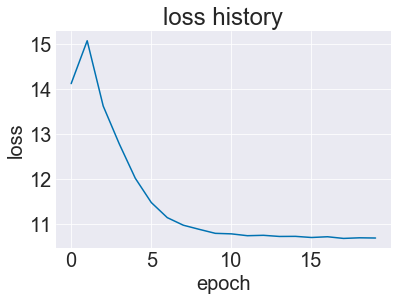

In [179]:
plt.plot(loss_history)
plt.title("loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

### c. Get and export word embedding vectors

- Implement in `word2vec.py` `get_word_vector()`
- Implement in `word2vec.py` `get_all_word_vectors()`
- Run the following code to save off the IMDb word embeddings

#### Test `get_word_vector`

In [180]:
print(f'The shape of one of your word vectors are {net.get_word_vector(word2ind, "james").shape} and should be (10,)')
print(f'The word vector for "james" looks like:\n{net.get_word_vector(word2ind, "james")}')

The shape of one of your word vectors are (10,) and should be (10,)
The word vector for "james" looks like:
[-0.0941815 -0.0702835 -0.1378837  0.292525   0.0571752 -0.0045876
 -0.1057064 -0.1824693  0.0241738 -0.0145152]


#### Test `get_all_word_vectors`

In [181]:
word_vecs = net.get_all_word_vectors(word2ind, unique_words)
print(f'Shape of word vectors: {word_vecs.shape} and should be (1016, 10)\n(for 10 reviews and embedding sz of 10)')

Shape of word vectors: (1016, 10) and should be (1016, 10)
(for 10 reviews and embedding sz of 10)


In [183]:
np.save('results/imdb_word_vectors', word_vecs)
np.save('results/imdb_word_strings', unique_words)